# Etude de marché - La poule qui chante

## Importation des librairie et des données

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram 
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import f
from scipy import stats

pd.options.display.float_format = '{:.0f}'.format
pd.set_option("max_rows", None)

production = pd.read_csv(r'C:/Users/alois/Desktop/Formation Aloïs/Projet 9 - La poule qui chante/Données FAO/Crops and livestock products.csv')
secu_ali= pd.read_csv(r'C:/Users/alois/Desktop/Formation Aloïs/Projet 9 - La poule qui chante/Données FAO/Food security indicators.csv')
commerce= pd.read_csv(r'C:/Users/alois/Desktop/Formation Aloïs/Projet 9 - La poule qui chante/Données FAO/Trade indicators.csv')
population= pd.read_csv(r'C:/Users/alois/Desktop/Formation Aloïs/Projet 9 - La poule qui chante/Données FAO/Population.csv')
cred_agri= pd.read_csv(r"C:/Users/alois/Desktop/Formation Aloïs/Projet 9 - La poule qui chante/Données FAO/Credit to agriculture.csv")


## Fonction pour cercles de correlation et plan factorielle

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(20,20))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(20,20))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# Nettoyage des données

In [3]:
production = production[['Area','Element','Year','Value']]
production['Value'] = production['Value']*1000
production = pd.pivot_table(production, values='Value',index=["Area","Year"],columns="Element")
production = production.rename(columns={"Stocks" : "Stocks (heads)"})


secu_ali = secu_ali[['Area','Item','Year','Unit','Value']]
secu_ali["Year"] = secu_ali["Year"].replace({"2016-2018" : 2017})
secu_ali['Year'] = secu_ali['Year'] .astype(str)
secu_ali["Year"]=pd.to_datetime(secu_ali["Year"])
secu_ali["Year"] = secu_ali["Year"].dt.year
secu_ali = pd.pivot_table(secu_ali, values='Value',index=["Area",'Year'],columns="Item")


commerce  = commerce[['Area',"Element Code","Element",'Year','Unit','Value']]
commerce = pd.pivot_table(commerce, values='Value',index=["Area","Year"],columns="Element Code")
commerce = commerce.rename(columns={5609 :'Import Quantity (heads)',5610:'Importe Quantity (tonnes)',5622:'Import Value (US$)',5909:'Export Quantity (heads)',5910:'Export Quantity (tonnes)',5922:'Export Value (US$)'})
commerce['Import Quantity (heads)']= commerce['Import Quantity (heads)']*1000
commerce['Import Value (US$)']=commerce['Import Value (US$)']*1000
commerce['Export Quantity (heads)']=commerce['Export Quantity (heads)']*1000
commerce['Export Value (US$)']=commerce['Export Value (US$)']*1000


population = population[["Area","Value","Year"]]
population = population.rename(columns={'Value' : 'Population'})
population['Population'] = population['Population']*1000
population =pd.pivot_table (population, values='Population', index=['Area'],columns = "Year")
population['Demographic Evolution']= ((population[2018]-population[2000])/population[2000])*100
population = population[[2018,"Demographic Evolution"]]
population = population.rename(columns={2018 : 'Population'})
population['Year']= 2018

cred_agri = cred_agri[["Area","Item","Year","Unit","Value"]]
cred_agri = pd.pivot_table(cred_agri, values='Value',index=["Area",'Year'],columns="Item")
cred_agri["Credit to Agriculture"]= cred_agri["Credit to Agriculture"]*1000000





In [4]:
recherche1  = pd.merge(secu_ali, production, on=('Area','Year'),how="outer")
recherche1  = pd.merge(recherche1, commerce, on=('Area','Year'),how="outer")
recherche1  = pd.merge(recherche1, population, on=('Area','Year'),how="outer")
recherche1  = pd.merge(recherche1, cred_agri, on=('Area','Year'),how="outer")
recherche1 = recherche1.reset_index()
recherche1 = recherche1.groupby('Area').mean()
recherche1 = recherche1.fillna(0)

In [5]:
recherche1

Year  \
Area                                                       
Afghanistan                                         2018   
Albania                                             2018   
Algeria                                             2018   
American Samoa                                      2018   
Andorra                                             2018   
Angola                                              2018   
Anguilla                                            2018   
Antigua and Barbuda                                 2018   
Argentina                                           2018   
Armenia                                             2018   
Aruba                                               2018   
Australia                                           2018   
Austria                                             2018   
Azerbaijan                                          2018   
Bahamas                                             2018   
Bahrain                                             2018   
Bangladesh                                          2018   
Barbados                                            2018   
Belarus                                             2018   
Belgium                                             2018   
Belize                                              2018   
Benin                                               2018   
Bermuda                                             2018   
Bhutan                                              2018   
Bolivia (Plurinational State of)                    2018   
Bonaire, Sint Eustatius and Saba                    2018   
Bosnia and Herzegovina                              2018   
Botswana                                            2018   
Brazil                                              2018   
British Virgin Islands                              2018   
Brunei Darussalam                                   2018   
Bulgaria                                            2018   
Burkina Faso                                        2018   
Burundi                                             2018   
C?te d'Ivoire                                       2018   
Cabo Verde                                          2018   
Cambodia                                            2018   
Cameroon                                            2018   
Canada                                              2018   
Cayman Islands                                      2018   
Central African Republic                            2018   
Chad                                                2018   
Channel Islands                                     2018   
Chile                                               2018   
China                                               2018   
China, Hong Kong SAR                                2018   
China, Macao SAR                                    2018   
China, Taiwan Province of                           2018   
China, mainland                                     2018   
Colombia                                            2018   
Comoros                                             2018   
Congo                                               2018   
Cook Islands                                        2018   
Costa Rica                                          2018   
Croatia                                             2018   
Cuba                                                2018   
Cura?ao                                             2018   
Cyprus                                              2018   
Czechia                                             2018   
Democratic People's Republic of Korea               2018   
Democratic Republic of the Congo                    2018   
Denmark                                             2018   
Djibouti                                            2018   
Dominica                                            2018   
Dominican Republic                                  2018   
Ecuador                         

# Première Analyse

## Classification Hierarchique

In [6]:
# préparation des données pour le clustering
X = recherche1.values
names = recherche1.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

In [7]:
plt.figure(figsize=(10,50))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(Z,labels = names,orientation = "left",distance_sort='descending',leaf_font_size=7)
plt.show()

## ACP 1

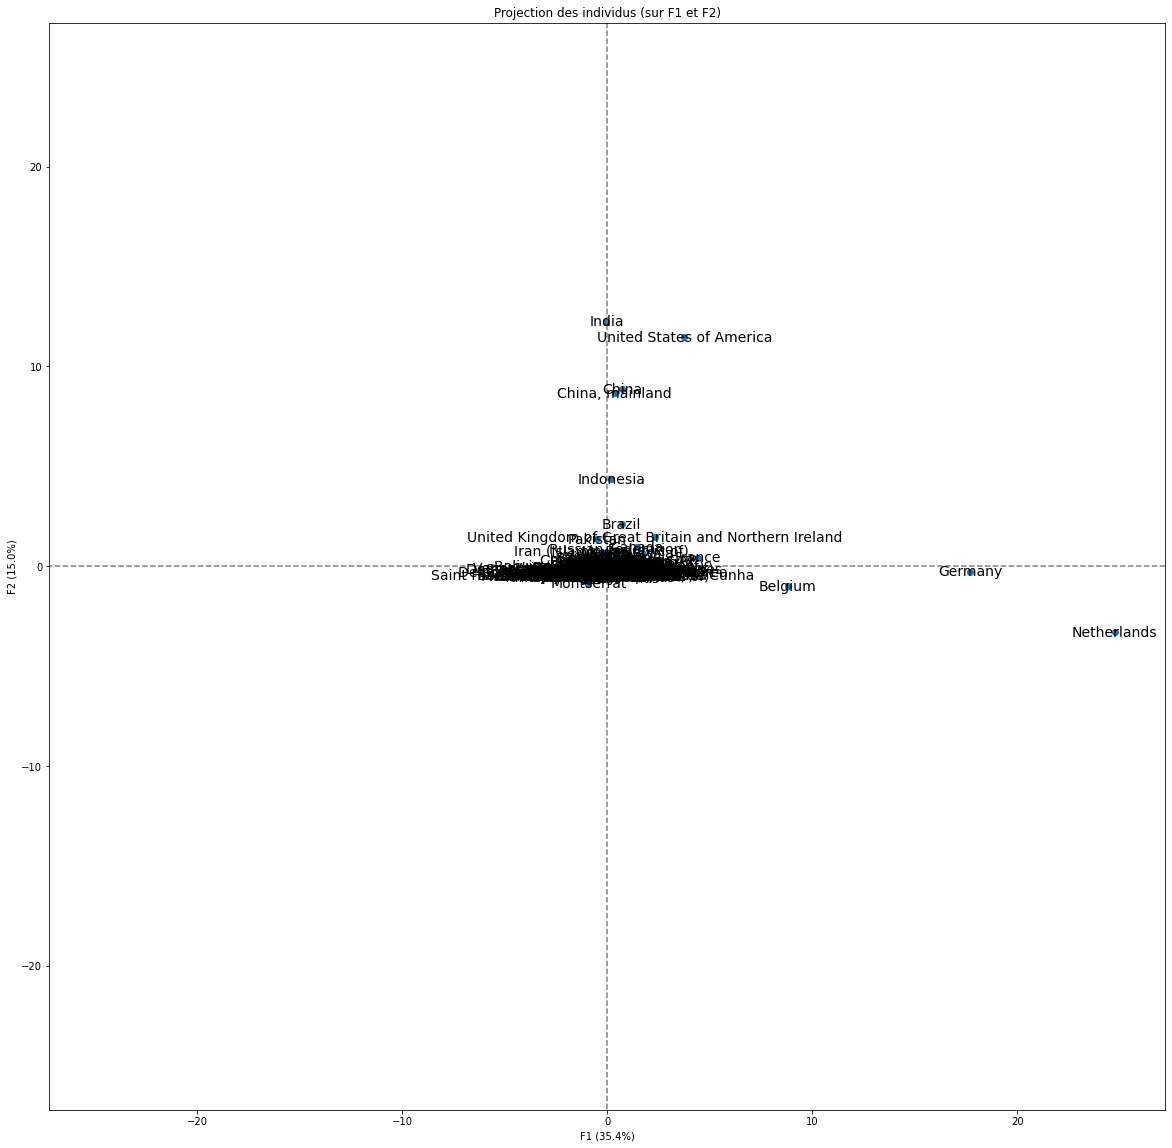

In [8]:
# choix du nombre de composantes à calculer
n_comp = 2

# selection des colonnes à prendre en compte dans l'ACP
recherche1_pca = recherche1


# préparation des données pour l'ACP
#recherche1_pca = recherche1_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = recherche1_pca.values
names = recherche1.index # ou data.index pour avoir les intitulés
features = recherche1.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()

### Nous pouvons observer que 3 pays se demarquent dans l'importation de volaille et pouvons nous interesser sur les differentes données de ces pays

### Pays-Bas

In [9]:
recherche1.loc["Netherlands"]

Year                                                                                         2018
Average supply of protein of animal origin (g/cap/day) (3-year average)                        68
Gross domestic product per capita, PPP, dissemination (constant 2011 international $)       55926
Political stability and absence of violence/terrorism (index)                                   1
Stocks (heads)                                                                          105184000
Import Quantity (heads)                                                                 453470333
Importe Quantity (tonnes)                                                                  746047
Import Value (US$)                                                                      757900000
Export Quantity (heads)                                                                 321330333
Export Quantity (tonnes)                                                                   119796
Export Value (US$)  

### Allemagne

In [10]:
recherche1.loc["Germany"]

Year                                                                                         2018
Average supply of protein of animal origin (g/cap/day) (3-year average)                        63
Gross domestic product per capita, PPP, dissemination (constant 2011 international $)       53352
Political stability and absence of violence/terrorism (index)                                   1
Stocks (heads)                                                                          160000000
Import Quantity (heads)                                                                 165262333
Importe Quantity (tonnes)                                                                   98682
Import Value (US$)                                                                      183086333
Export Quantity (heads)                                                                 312697667
Export Quantity (tonnes)                                                                   539250
Export Value (US$)  

### Belgique

In [11]:
recherche1.loc["Belgium"]

Year                                                                                         2018
Average supply of protein of animal origin (g/cap/day) (3-year average)                        58
Gross domestic product per capita, PPP, dissemination (constant 2011 international $)       51099
Political stability and absence of violence/terrorism (index)                                   0
Stocks (heads)                                                                           29616000
Import Quantity (heads)                                                                 143019000
Importe Quantity (tonnes)                                                                  218035
Import Value (US$)                                                                      204934667
Export Quantity (heads)                                                                 142011333
Export Quantity (tonnes)                                                                   102802
Export Value (US$)  

# Deuxieme Analyse

### Nous allons maintenant effectuer une deuxieme analyse en selectionnant les variables qui nous interesse le plus :
- L'apport moyen de proteine animal en gramme/habitant/day
- La stabilité politique
- Le PIB par habitant
- La quantité de "tête" importées
- La population
- L'évolution démographique

In [12]:
recherche2 = recherche1[['Average supply of protein of animal origin (g/cap/day) (3-year average)',"Political stability and absence of violence/terrorism (index)","Gross domestic product per capita, PPP, dissemination (constant 2011 international $)","Import Quantity (heads)","Population","Demographic Evolution"]]

## Méthode des k-means

#### Nous choisirons 6 clusters pour avoir une recherche plus affinée

In [13]:
# Nombre de clusters souhaités
n_clust = 6
X = recherche2.values

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)


# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=2).fit(X)
X_projected = pca.transform(X)
plt.figure(figsize=(20,10))
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=0.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False);

<ipython-input-13-422bf3745442>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=0.8)


In [14]:
#Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

# ACP 2

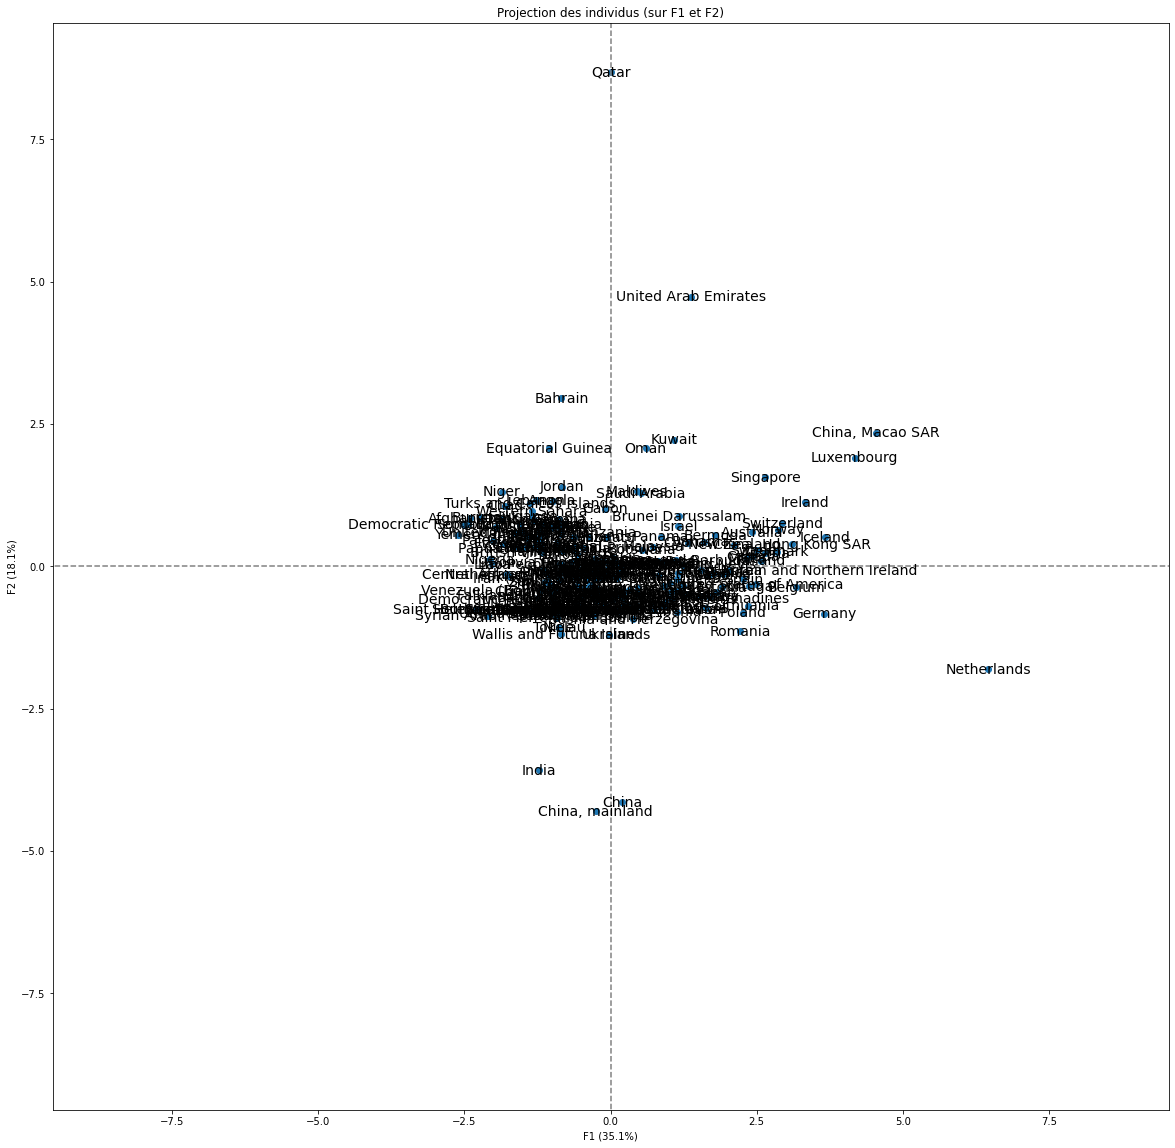

In [15]:
# choix du nombre de composantes à calculer
n_comp = 2

# selection des colonnes à prendre en compte dans l'ACP
recherche2_pca = recherche2


# préparation des données pour l'ACP
#recherche1_pca = recherche1_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = recherche2_pca.values
names = recherche2.index # ou data.index pour avoir les intitulés
features = recherche2.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()

In [16]:
predictions =km.predict(recherche2)
recherche2['cluster-kmeans'] = pd.Series(predictions, index=recherche2.index)

<ipython-input-16-450241928d44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recherche2['cluster-kmeans'] = pd.Series(predictions, index=recherche2.index)


In [17]:
recherche2

Average supply of protein of animal origin (g/cap/day) (3-year average)  \
Area                                                                                                                          
Afghanistan                                                                                        11                         
Albania                                                                                            63                         
Algeria                                                                                            26                         
American Samoa                                                                                      0                         
Andorra                                                                                             0                         
Angola                                                                                             16                         
Anguilla                                                                                            0                         
Antigua and Barbuda                                                                                50                         
Argentina                                                                                          67                         
Armenia                                                                                            45                         
Aruba                                                                                               0                         
Australia                                                                                          72                         
Austria                                                                                            65                         
Azerbaijan                                                                                         32                         
Bahamas                                                                                            52                         
Bahrain                                                                                             0                         
Bangladesh                                                                                         12                         
Barbados                                                                                           49                         
Belarus                                                                                            51                         
Belgium                                                                                            58                         
Belize                                                                                             27                         
Benin                                                                                              13                         
Bermuda                                                                                             0                         
Bhutan                                                                                              0                         
Bolivia (Plurinational State of)                                                                   35                         
Bonaire, Sint Eustatius and Saba                                                                    0                         
Bosnia and Herzegovina                                                                             36                         
Botswana                                                                                           28                         
Brazil                                                                                             53                         
British Virgin Islands                                                                              0              

# Boxplot des clusters

In [18]:
sns.boxplot( x = recherche2["cluster-kmeans"], y = recherche2["Average supply of protein of animal origin (g/cap/day) (3-year average)"]);

In [19]:
sns.boxplot( x = recherche2["cluster-kmeans"], y = recherche2["Population"]);

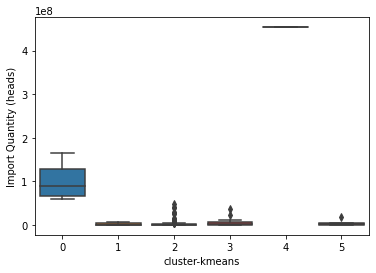

In [20]:
sns.boxplot( x = recherche2["cluster-kmeans"], y = recherche2["Import Quantity (heads)"]);

# Heatmap K-Means

In [21]:
recherche2 = recherche2.set_index("cluster-kmeans")
recherche2 = recherche2.groupby('cluster-kmeans').mean()
normalized_recherche2=(recherche2-recherche2.min())/(recherche2.max()-recherche2.min())

In [22]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(normalized_recherche2)
plt.savefig('Heatmap-Kmeans.pdf', bbox_inches="tight")